In [9]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from data_reader import affretement, gen_dict_fourn, gen_camion_cap, gen_previsions_vente, gen_amortissement
from pfut import gen_usines_from_list, min_fourn_usine_i, min_fourn_usine_f, min_fourn_vente
from cout import cout_affretement,cout_amortissement

In [3]:
### Récupération des données des tableaux
dict_affretement = affretement()
dict_fourn = gen_dict_fourn(dict_affretement)
dict_camion = gen_camion_cap()
dict_previsions = gen_previsions_vente()
dict_amortissement = gen_amortissement()

In [4]:
### Set up d'une architecture
# Ordre des villes : 
#       ['Madrid','Marseille','Turin','Munich','Bruxelles']
table_usines_f = [
    [0,0,0,0,1],
    [0,0,0,1,0],
    [0,0,1,0,0],
    [0,1,0,0,0],
    [1,0,0,0,0],

    [0,0,0,1,1],
    [0,0,1,0,1],
    [0,1,0,0,1],
    [1,0,0,0,1],
    [0,0,1,1,0],
    [0,1,0,1,0],
    [1,0,0,1,0],
    [0,1,1,0,0],
    [1,0,1,0,0],
    [1,1,0,0,0],

    [0,0,1,1,1],
    [0,1,0,1,1],
    [1,0,0,1,1],
    [0,1,1,0,1],
    [1,0,1,0,1],
    [0,1,1,1,0],
    [1,0,1,1,0],
    [1,1,1,0,0],
    [1,1,0,0,1],
    [1,1,0,1,0],

    [0,1,1,1,1],
    [1,0,1,1,1],
    [1,1,0,1,1],
    [1,1,1,0,1],
    [1,1,1,1,0],

    [1,1,1,1,1]
]

In [5]:
dict_usines_f_cost, dict_usines_i_cost


NameError: name 'dict_usines_f_cost' is not defined

In [6]:
def opti_archi(archi) : ## Calcule la meilleure arborescence pour une architecture donnée
    ## Creation du dictionnaire des usines finales
    dict_usines_f = gen_usines_from_list(archi)
    ## Création du dictionnaire des usines intermédiaires
    dict_usines_i = gen_usines_from_list(archi)


    ##### Recherche des chemins les moins couteux

    ## Chemins optimaux pour les usines intermédiaires
    dict_usines_i_cost = min_fourn_usine_i(dict_usines_i, dict_fourn, dict_affretement, dict_camion)

    # Affichage du dictionnaire de plus court chemin entre les usines intermédiaires et leurs fournisseurs
    print('Arborescence usine intermediaire :')
    for usine in dict_usines_i_cost.keys():
        dict_usine = dict_usines_i_cost[usine]
        print('\t', usine)
        for matiere in dict_usine.keys():
            print('\t\t', matiere, dict_usine[matiere])
        

    ## Chemins optimaux pour les usines finales
    dict_usines_f_cost = min_fourn_usine_f(dict_usines_f, dict_usines_i_cost, dict_fourn, dict_affretement, dict_camion)

    # Affichage du dictionnaire de plus court chemin entre les usines finales et leurs fournisseurs
    print('\nArborescence usine finale :')
    for usine in dict_usines_f_cost.keys():
        dict_usine = dict_usines_f_cost[usine]
        print('\t',usine)
        for matiere in dict_usine.keys():
            print('\t\t', matiere, dict_usine[matiere])

            
    ## Chemins optimaux pour les points de ventes
    dict_vente_cost = min_fourn_vente(dict_usines_f_cost, dict_affretement, dict_camion, dict_previsions)

    # Affichage du dictionnaire de plus court chemin entre les points de ventes et leurs fournisseurs
    print('\nArborescence point de vente :')
    for point_vente in dict_vente_cost.keys():
        dict_point_vente = dict_vente_cost[point_vente]
        print('\t',point_vente)
        for matiere in dict_point_vente.keys():
            print('\t\t', matiere, dict_point_vente[matiere])

    ##### Calcul du cout global 

    ## Calcul et affichage des couts
    cout_aff = cout_affretement(dict_vente_cost, dict_previsions)
    print('cout_aff = ',cout_aff)
    cout_amo = cout_amortissement(dict_usines_f, dict_usines_i, dict_amortissement)
    print('cout_amo = ',cout_amo)

    ##### Cascade pour répartir des volumes de demande dans les usines finales et intermédiaires
    for point_vente in dict_vente_cost.keys():
        dict_usines_f_cost[dict_vente_cost[point_vente]['Usine_f']]['Volume'] += dict_vente_cost[point_vente]['Volume']

    for usine_f in dict_usines_f_cost.keys():
        dict_usines_i_cost[dict_usines_f_cost[usine_f]['Usine_i'][0]]['Volume'] += dict_usines_f_cost[usine_f]['Volume']

    ##### Préparation a l'affichage du graph
    import networkx as nx
    import matplotlib.pyplot as plt
    dict_colors = {}
    color_index = 0
    G = nx.Graph()

    ## Creation noeud fournisseur
    for matiere in dict_fourn.keys():
        dict_colors['Fournisseur : '+matiere] = color_index
        color_index += 1
        for ville in dict_fourn[matiere]:
            if matiere=='Tube':
                subset = 9
            else:
                subset = 10
            volume = 0
            if matiere != 'Tube':
                for usine in dict_usines_i_cost.keys():
                    if dict_usines_i_cost[usine][matiere][0] == ville:
                        volume += dict_usines_i_cost[usine]['Volume']
            else:
                for usine in dict_usines_f_cost.keys():
                    if dict_usines_f_cost[usine][matiere][0] == ville:
                        volume += dict_usines_f_cost[usine]['Volume']
            G.add_node(matiere+ville, node_type='Fournisseur : '+matiere, place=ville, cout_unitaire = 0, subset=subset, volume=volume)


    ## Création noeud usine intermédiaire
    dict_colors['Usine intermédiaire'] = color_index
    color_index += 1
    for usine in dict_usines_i_cost.keys():
        G.add_node('Usine_i'+usine, node_type='Usine intermédiaire', place=usine, cout_unitaire = dict_usines_i_cost[usine]['totalCost'], subset=9, volume=dict_usines_i_cost[usine]['Volume'])
        i = 0
        for matiere in dict_usines_i_cost[usine].keys():
            if i<3:
                i+=1
                G.add_edge('Usine_i'+usine, matiere+dict_usines_i_cost[usine][matiere][0], volume=0)



    ## Création noeud usine finale
    dict_colors['Usine finale'] = color_index
    color_index += 1
    for usine in dict_usines_f_cost.keys():
        G.add_node('Usine_f'+usine, node_type='Usine finale', place=usine, cout_unitaire = dict_usines_f_cost[usine]['totalCost'], subset=8, volume=dict_usines_f_cost[usine]['Volume'])
        G.add_edge('Usine_f'+usine, 'Tube'+dict_usines_f_cost[usine]['Tube'][0], volume=0)
        G.add_edge('Usine_f'+usine, 'Usine_i'+dict_usines_f_cost[usine]['Usine_i'][0], volume=0)

    ## Création noeud point de vente
    dict_colors['Point de vente'] = color_index
    color_index += 1
    for site in dict_vente_cost.keys():
        G.add_node('Point de vente'+site, node_type='Point de vente', place=site, cout_unitaire = dict_vente_cost[site]['totalCost'], subset=7, volume=dict_vente_cost[site]['Volume'])
        G.add_edge('Point de vente'+site, 'Usine_f'+dict_vente_cost[site]['Usine_f'], volume=dict_vente_cost[site]['Volume'])

    
    ## Création de la liste des labels et répartition des couleurs
    labels = {n : G.nodes[n]['node_type']+'\n'+G.nodes[n]['place']+'\nVolume : '+str(G.nodes[n]['volume'])+f"\nCoût unitaire : {G.nodes[n]['cout_unitaire']:.2f}" for n in G.nodes}
    colors = [dict_colors[G.nodes[n]['node_type']] for n in G.nodes]
    sizes = []
    for n in list(G):
        sizes.append(G.nodes[n]['volume'])


    ## Affichage
    pos = nx.multipartite_layout(G)
    nx.draw(G, with_labels=True, labels=labels, node_color = colors, pos=pos, node_size = sizes)
    plt.show()

    return (cout_aff,cout_amo)

Arborescence usine intermediaire :
	 Bruxelles
		 Tissus ('Londres', 1.32)
		 Mousse ('Amsterdam', 1.696)
		 Plastique ('Amsterdam', 1.2732732732732732)
		 totalCost 4.289273273273273
		 Volume 0

Arborescence usine finale :
	 Bruxelles
		 Tube ('Dublin', 1.862)
		 Usine_i ('Bruxelles', 0.0)
		 totalCost 6.151273273273273
		 Volume 0

Arborescence point de vente :
	 Madrid
		 Usine_f Bruxelles
		 totalCost 39.651273273273276
		 Volume 120
	 Marseille
		 Usine_f Bruxelles
		 totalCost 27.53127327327327
		 Volume 240
	 Turin
		 Usine_f Bruxelles
		 totalCost 27.611273273273273
		 Volume 110
	 Munich
		 Usine_f Bruxelles
		 totalCost 21.991273273273272
		 Volume 160
	 Bruxelles
		 Usine_f Bruxelles
		 totalCost 6.151273273273273
		 Volume 340
	 Londres
		 Usine_f Bruxelles
		 totalCost 12.751273273273274
		 Volume 260
	 Amsterdam
		 Usine_f Bruxelles
		 totalCost 10.391273273273274
		 Volume 270
	 Dublin
		 Usine_f Bruxelles
		 totalCost 24.771273273273273
		 Volume 220
	 Cologne
		 Usine

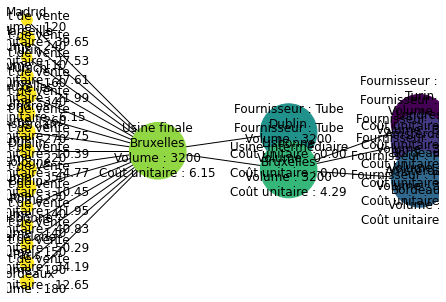

Arborescence usine intermediaire :
	 Munich
		 Tissus ('Turin', 2.94)
		 Mousse ('Amsterdam', 6.784)
		 Plastique ('Amsterdam', 5.093093093093093)
		 totalCost 14.817093093093092
		 Volume 0

Arborescence usine finale :
	 Munich
		 Tube ('Dublin', 3.418)
		 Usine_i ('Munich', 0.0)
		 totalCost 18.23509309309309
		 Volume 0

Arborescence point de vente :
	 Madrid
		 Usine_f Munich
		 totalCost 59.87509309309309
		 Volume 120
	 Marseille
		 Usine_f Munich
		 totalCost 39.73509309309309
		 Volume 240
	 Turin
		 Usine_f Munich
		 totalCost 32.93509309309309
		 Volume 110
	 Munich
		 Usine_f Munich
		 totalCost 18.23509309309309
		 Volume 160
	 Bruxelles
		 Usine_f Munich
		 totalCost 34.07509309309309
		 Volume 340
	 Londres
		 Usine_f Munich
		 totalCost 40.37509309309309
		 Volume 260
	 Amsterdam
		 Usine_f Munich
		 totalCost 35.19509309309309
		 Volume 270
	 Dublin
		 Usine_f Munich
		 totalCost 52.41509309309309
		 Volume 220
	 Cologne
		 Usine_f Munich
		 totalCost 30.13509309309309


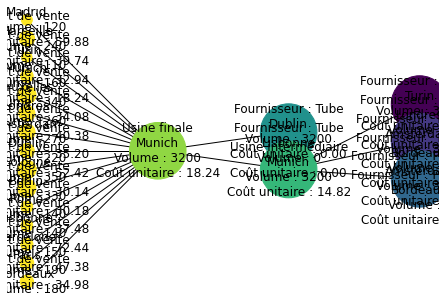

Arborescence usine intermediaire :
	 Turin
		 Tissus ('Turin', 0.0)
		 Mousse ('Bordeaux', 6.84)
		 Plastique ('Bordeaux', 5.135135135135135)
		 totalCost 11.975135135135135
		 Volume 0

Arborescence usine finale :
	 Turin
		 Tube ('Dublin', 3.694)
		 Usine_i ('Turin', 0.0)
		 totalCost 15.669135135135136
		 Volume 0

Arborescence point de vente :
	 Madrid
		 Usine_f Turin
		 totalCost 44.92913513513514
		 Volume 120
	 Marseille
		 Usine_f Turin
		 totalCost 23.829135135135136
		 Volume 240
	 Turin
		 Usine_f Turin
		 totalCost 15.669135135135136
		 Volume 110
	 Munich
		 Usine_f Turin
		 totalCost 30.369135135135135
		 Volume 160
	 Bruxelles
		 Usine_f Turin
		 totalCost 37.12913513513514
		 Volume 340
	 Londres
		 Usine_f Turin
		 totalCost 40.58913513513514
		 Volume 260
	 Amsterdam
		 Usine_f Turin
		 totalCost 40.68913513513513
		 Volume 270
	 Dublin
		 Usine_f Turin
		 totalCost 52.60913513513513
		 Volume 220
	 Cologne
		 Usine_f Turin
		 totalCost 36.90913513513513
		 Volume 35

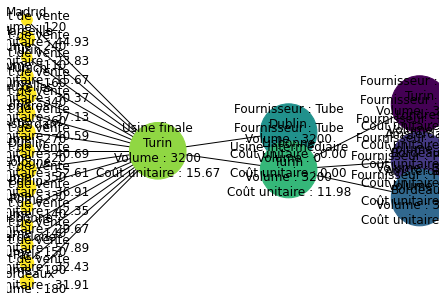

Arborescence usine intermediaire :
	 Marseille
		 Tissus ('Turin', 1.632)
		 Mousse ('Bordeaux', 5.424)
		 Plastique ('Bordeaux', 4.072072072072072)
		 totalCost 11.128072072072072
		 Volume 0

Arborescence usine finale :
	 Marseille
		 Tube ('Lisbonne', 3.6)
		 Usine_i ('Marseille', 0.0)
		 totalCost 14.728072072072072
		 Volume 0

Arborescence point de vente :
	 Madrid
		 Usine_f Marseille
		 totalCost 37.76807207207207
		 Volume 120
	 Marseille
		 Usine_f Marseille
		 totalCost 14.728072072072072
		 Volume 240
	 Turin
		 Usine_f Marseille
		 totalCost 22.88807207207207
		 Volume 110
	 Munich
		 Usine_f Marseille
		 totalCost 36.228072072072074
		 Volume 160
	 Bruxelles
		 Usine_f Marseille
		 totalCost 36.10807207207207
		 Volume 340
	 Londres
		 Usine_f Marseille
		 totalCost 39.46807207207207
		 Volume 260
	 Amsterdam
		 Usine_f Marseille
		 totalCost 40.16807207207207
		 Volume 270
	 Dublin
		 Usine_f Marseille
		 totalCost 51.48807207207207
		 Volume 220
	 Cologne
		 Usine_f Mar

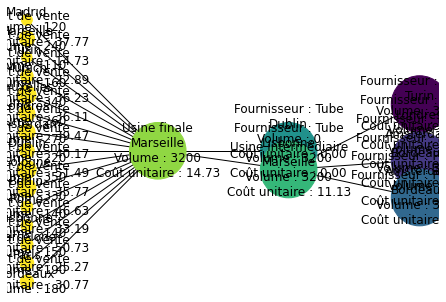

Arborescence usine intermediaire :
	 Madrid
		 Tissus ('Turin', 5.852)
		 Mousse ('Bordeaux', 5.936)
		 Plastique ('Bordeaux', 4.456456456456457)
		 totalCost 16.244456456456458
		 Volume 0

Arborescence usine finale :
	 Madrid
		 Tube ('Lisbonne', 1.318)
		 Usine_i ('Madrid', 0.0)
		 totalCost 17.56245645645646
		 Volume 0

Arborescence point de vente :
	 Madrid
		 Usine_f Madrid
		 totalCost 17.56245645645646
		 Volume 120
	 Marseille
		 Usine_f Madrid
		 totalCost 40.60245645645646
		 Volume 240
	 Turin
		 Usine_f Madrid
		 totalCost 46.822456456456464
		 Volume 110
	 Munich
		 Usine_f Madrid
		 totalCost 59.20245645645646
		 Volume 160
	 Bruxelles
		 Usine_f Madrid
		 totalCost 51.06245645645646
		 Volume 340
	 Londres
		 Usine_f Madrid
		 totalCost 53.222456456456456
		 Volume 260
	 Amsterdam
		 Usine_f Madrid
		 totalCost 55.02245645645646
		 Volume 270
	 Dublin
		 Usine_f Madrid
		 totalCost 65.26245645645646
		 Volume 220
	 Cologne
		 Usine_f Madrid
		 totalCost 54.722456456456

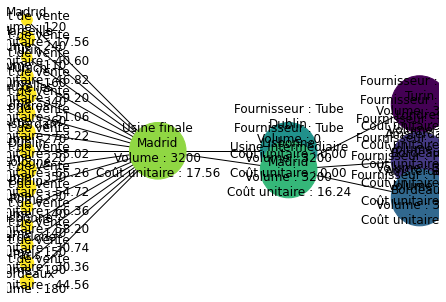

Arborescence usine intermediaire :
	 Munich
		 Tissus ('Turin', 2.94)
		 Mousse ('Amsterdam', 6.784)
		 Plastique ('Amsterdam', 5.093093093093093)
		 totalCost 14.817093093093092
		 Volume 0
	 Bruxelles
		 Tissus ('Londres', 1.32)
		 Mousse ('Amsterdam', 1.696)
		 Plastique ('Amsterdam', 1.2732732732732732)
		 totalCost 4.289273273273273
		 Volume 0

Arborescence usine finale :
	 Munich
		 Tube ('Dublin', 3.418)
		 Usine_i ('Bruxelles', 9.48502994011976)
		 totalCost 17.192303213393032
		 Volume 0
	 Bruxelles
		 Tube ('Dublin', 1.862)
		 Usine_i ('Bruxelles', 0.0)
		 totalCost 6.151273273273273
		 Volume 0

Arborescence point de vente :
	 Madrid
		 Usine_f Bruxelles
		 totalCost 39.651273273273276
		 Volume 120
	 Marseille
		 Usine_f Bruxelles
		 totalCost 27.53127327327327
		 Volume 240
	 Turin
		 Usine_f Bruxelles
		 totalCost 27.611273273273273
		 Volume 110
	 Munich
		 Usine_f Munich
		 totalCost 17.192303213393032
		 Volume 160
	 Bruxelles
		 Usine_f Bruxelles
		 totalCost 6.15127

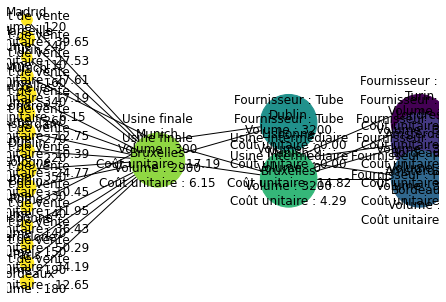

Arborescence usine intermediaire :
	 Turin
		 Tissus ('Turin', 0.0)
		 Mousse ('Bordeaux', 6.84)
		 Plastique ('Bordeaux', 5.135135135135135)
		 totalCost 11.975135135135135
		 Volume 0
	 Bruxelles
		 Tissus ('Londres', 1.32)
		 Mousse ('Amsterdam', 1.696)
		 Plastique ('Amsterdam', 1.2732732732732732)
		 totalCost 4.289273273273273
		 Volume 0

Arborescence usine finale :
	 Turin
		 Tube ('Dublin', 3.694)
		 Usine_i ('Turin', 12.850299401197605)
		 totalCost 15.669135135135136
		 Volume 0
	 Bruxelles
		 Tube ('Dublin', 1.862)
		 Usine_i ('Bruxelles', 0.0)
		 totalCost 6.151273273273273
		 Volume 0

Arborescence point de vente :
	 Madrid
		 Usine_f Bruxelles
		 totalCost 39.651273273273276
		 Volume 120
	 Marseille
		 Usine_f Turin
		 totalCost 23.829135135135136
		 Volume 240
	 Turin
		 Usine_f Turin
		 totalCost 15.669135135135136
		 Volume 110
	 Munich
		 Usine_f Bruxelles
		 totalCost 21.991273273273272
		 Volume 160
	 Bruxelles
		 Usine_f Bruxelles
		 totalCost 6.151273273273273
	

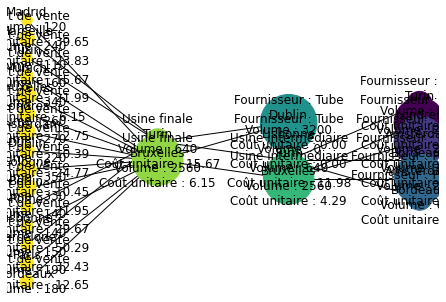

Arborescence usine intermediaire :
	 Marseille
		 Tissus ('Turin', 1.632)
		 Mousse ('Bordeaux', 5.424)
		 Plastique ('Bordeaux', 4.072072072072072)
		 totalCost 11.128072072072072
		 Volume 0
	 Bruxelles
		 Tissus ('Londres', 1.32)
		 Mousse ('Amsterdam', 1.696)
		 Plastique ('Amsterdam', 1.2732732732732732)
		 totalCost 4.289273273273273
		 Volume 0

Arborescence usine finale :
	 Marseille
		 Tube ('Lisbonne', 3.6)
		 Usine_i ('Marseille', 12.802395209580839)
		 totalCost 14.728072072072072
		 Volume 0
	 Bruxelles
		 Tube ('Dublin', 1.862)
		 Usine_i ('Bruxelles', 0.0)
		 totalCost 6.151273273273273
		 Volume 0

Arborescence point de vente :
	 Madrid
		 Usine_f Marseille
		 totalCost 37.76807207207207
		 Volume 120
	 Marseille
		 Usine_f Marseille
		 totalCost 14.728072072072072
		 Volume 240
	 Turin
		 Usine_f Marseille
		 totalCost 22.88807207207207
		 Volume 110
	 Munich
		 Usine_f Bruxelles
		 totalCost 21.991273273273272
		 Volume 160
	 Bruxelles
		 Usine_f Bruxelles
		 totalCos

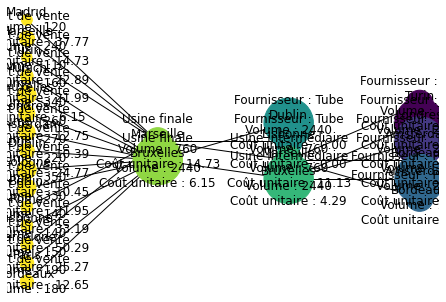

Arborescence usine intermediaire :
	 Madrid
		 Tissus ('Turin', 5.852)
		 Mousse ('Bordeaux', 5.936)
		 Plastique ('Bordeaux', 4.456456456456457)
		 totalCost 16.244456456456458
		 Volume 0
	 Bruxelles
		 Tissus ('Londres', 1.32)
		 Mousse ('Amsterdam', 1.696)
		 Plastique ('Amsterdam', 1.2732732732732732)
		 totalCost 4.289273273273273
		 Volume 0

Arborescence usine finale :
	 Madrid
		 Tube ('Lisbonne', 1.318)
		 Usine_i ('Madrid', 20.059880239520957)
		 totalCost 17.56245645645646
		 Volume 0
	 Bruxelles
		 Tube ('Dublin', 1.862)
		 Usine_i ('Bruxelles', 0.0)
		 totalCost 6.151273273273273
		 Volume 0

Arborescence point de vente :
	 Madrid
		 Usine_f Madrid
		 totalCost 17.56245645645646
		 Volume 120
	 Marseille
		 Usine_f Bruxelles
		 totalCost 27.53127327327327
		 Volume 240
	 Turin
		 Usine_f Bruxelles
		 totalCost 27.611273273273273
		 Volume 110
	 Munich
		 Usine_f Bruxelles
		 totalCost 21.991273273273272
		 Volume 160
	 Bruxelles
		 Usine_f Bruxelles
		 totalCost 6.1512732

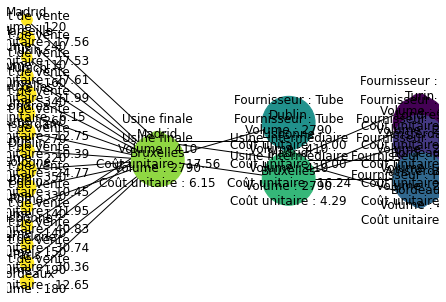

Arborescence usine intermediaire :
	 Turin
		 Tissus ('Turin', 0.0)
		 Mousse ('Bordeaux', 6.84)
		 Plastique ('Bordeaux', 5.135135135135135)
		 totalCost 11.975135135135135
		 Volume 0
	 Munich
		 Tissus ('Turin', 2.94)
		 Mousse ('Amsterdam', 6.784)
		 Plastique ('Amsterdam', 5.093093093093093)
		 totalCost 14.817093093093092
		 Volume 0

Arborescence usine finale :
	 Turin
		 Tube ('Dublin', 3.694)
		 Usine_i ('Turin', 8.802395209580839)
		 totalCost 15.669135135135136
		 Volume 0
	 Munich
		 Tube ('Dublin', 3.418)
		 Usine_i ('Munich', 0.0)
		 totalCost 18.23509309309309
		 Volume 0

Arborescence point de vente :
	 Madrid
		 Usine_f Turin
		 totalCost 44.92913513513514
		 Volume 120
	 Marseille
		 Usine_f Turin
		 totalCost 23.829135135135136
		 Volume 240
	 Turin
		 Usine_f Turin
		 totalCost 15.669135135135136
		 Volume 110
	 Munich
		 Usine_f Munich
		 totalCost 18.23509309309309
		 Volume 160
	 Bruxelles
		 Usine_f Munich
		 totalCost 34.07509309309309
		 Volume 340
	 Londres
	

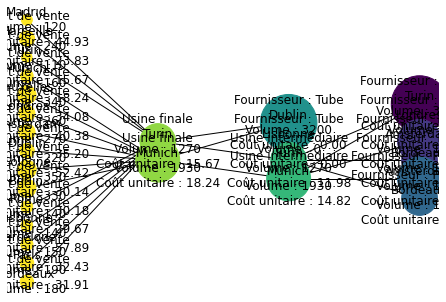

Arborescence usine intermediaire :
	 Marseille
		 Tissus ('Turin', 1.632)
		 Mousse ('Bordeaux', 5.424)
		 Plastique ('Bordeaux', 4.072072072072072)
		 totalCost 11.128072072072072
		 Volume 0
	 Munich
		 Tissus ('Turin', 2.94)
		 Mousse ('Amsterdam', 6.784)
		 Plastique ('Amsterdam', 5.093093093093093)
		 totalCost 14.817093093093092
		 Volume 0

Arborescence usine finale :
	 Marseille
		 Tube ('Lisbonne', 3.6)
		 Usine_i ('Marseille', 12.874251497005988)
		 totalCost 14.728072072072072
		 Volume 0
	 Munich
		 Tube ('Dublin', 3.418)
		 Usine_i ('Munich', 0.0)
		 totalCost 18.23509309309309
		 Volume 0

Arborescence point de vente :
	 Madrid
		 Usine_f Marseille
		 totalCost 37.76807207207207
		 Volume 120
	 Marseille
		 Usine_f Marseille
		 totalCost 14.728072072072072
		 Volume 240
	 Turin
		 Usine_f Marseille
		 totalCost 22.88807207207207
		 Volume 110
	 Munich
		 Usine_f Munich
		 totalCost 18.23509309309309
		 Volume 160
	 Bruxelles
		 Usine_f Munich
		 totalCost 34.0750930930930

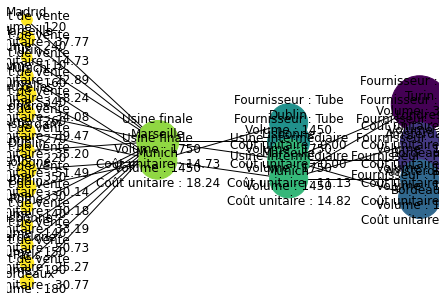

Arborescence usine intermediaire :
	 Madrid
		 Tissus ('Turin', 5.852)
		 Mousse ('Bordeaux', 5.936)
		 Plastique ('Bordeaux', 4.456456456456457)
		 totalCost 16.244456456456458
		 Volume 0
	 Munich
		 Tissus ('Turin', 2.94)
		 Mousse ('Amsterdam', 6.784)
		 Plastique ('Amsterdam', 5.093093093093093)
		 totalCost 14.817093093093092
		 Volume 0

Arborescence usine finale :
	 Madrid
		 Tube ('Lisbonne', 1.318)
		 Usine_i ('Madrid', 24.934131736526947)
		 totalCost 17.56245645645646
		 Volume 0
	 Munich
		 Tube ('Dublin', 3.418)
		 Usine_i ('Munich', 0.0)
		 totalCost 18.23509309309309
		 Volume 0

Arborescence point de vente :
	 Madrid
		 Usine_f Madrid
		 totalCost 17.56245645645646
		 Volume 120
	 Marseille
		 Usine_f Munich
		 totalCost 39.73509309309309
		 Volume 240
	 Turin
		 Usine_f Munich
		 totalCost 32.93509309309309
		 Volume 110
	 Munich
		 Usine_f Munich
		 totalCost 18.23509309309309
		 Volume 160
	 Bruxelles
		 Usine_f Munich
		 totalCost 34.07509309309309
		 Volume 340
	 

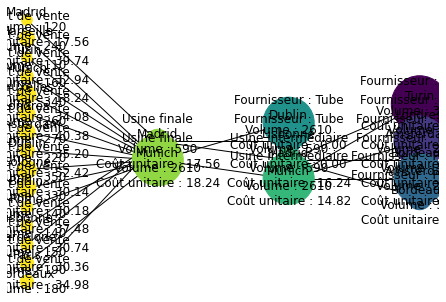

Arborescence usine intermediaire :
	 Marseille
		 Tissus ('Turin', 1.632)
		 Mousse ('Bordeaux', 5.424)
		 Plastique ('Bordeaux', 4.072072072072072)
		 totalCost 11.128072072072072
		 Volume 0
	 Turin
		 Tissus ('Turin', 0.0)
		 Mousse ('Bordeaux', 6.84)
		 Plastique ('Bordeaux', 5.135135135135135)
		 totalCost 11.975135135135135
		 Volume 0

Arborescence usine finale :
	 Marseille
		 Tube ('Lisbonne', 3.6)
		 Usine_i ('Marseille', 4.88622754491018)
		 totalCost 14.728072072072072
		 Volume 0
	 Turin
		 Tube ('Dublin', 3.694)
		 Usine_i ('Turin', 0.0)
		 totalCost 15.669135135135136
		 Volume 0

Arborescence point de vente :
	 Madrid
		 Usine_f Marseille
		 totalCost 37.76807207207207
		 Volume 120
	 Marseille
		 Usine_f Marseille
		 totalCost 14.728072072072072
		 Volume 240
	 Turin
		 Usine_f Turin
		 totalCost 15.669135135135136
		 Volume 110
	 Munich
		 Usine_f Turin
		 totalCost 30.369135135135135
		 Volume 160
	 Bruxelles
		 Usine_f Marseille
		 totalCost 36.10807207207207
		 Vol

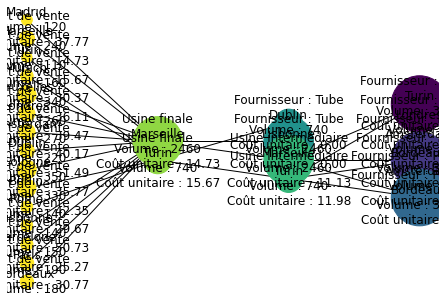

Arborescence usine intermediaire :
	 Madrid
		 Tissus ('Turin', 5.852)
		 Mousse ('Bordeaux', 5.936)
		 Plastique ('Bordeaux', 4.456456456456457)
		 totalCost 16.244456456456458
		 Volume 0
	 Turin
		 Tissus ('Turin', 0.0)
		 Mousse ('Bordeaux', 6.84)
		 Plastique ('Bordeaux', 5.135135135135135)
		 totalCost 11.975135135135135
		 Volume 0

Arborescence usine finale :
	 Madrid
		 Tube ('Lisbonne', 1.318)
		 Usine_i ('Madrid', 17.520958083832337)
		 totalCost 17.56245645645646
		 Volume 0
	 Turin
		 Tube ('Dublin', 3.694)
		 Usine_i ('Turin', 0.0)
		 totalCost 15.669135135135136
		 Volume 0

Arborescence point de vente :
	 Madrid
		 Usine_f Madrid
		 totalCost 17.56245645645646
		 Volume 120
	 Marseille
		 Usine_f Turin
		 totalCost 23.829135135135136
		 Volume 240
	 Turin
		 Usine_f Turin
		 totalCost 15.669135135135136
		 Volume 110
	 Munich
		 Usine_f Turin
		 totalCost 30.369135135135135
		 Volume 160
	 Bruxelles
		 Usine_f Turin
		 totalCost 37.12913513513514
		 Volume 340
	 Londres

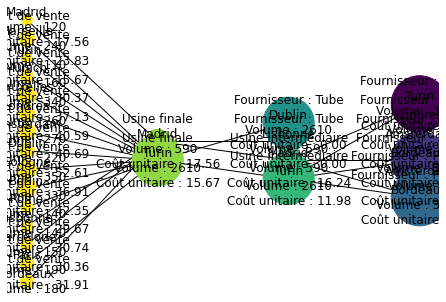

Arborescence usine intermediaire :
	 Madrid
		 Tissus ('Turin', 5.852)
		 Mousse ('Bordeaux', 5.936)
		 Plastique ('Bordeaux', 4.456456456456457)
		 totalCost 16.244456456456458
		 Volume 0
	 Marseille
		 Tissus ('Turin', 1.632)
		 Mousse ('Bordeaux', 5.424)
		 Plastique ('Bordeaux', 4.072072072072072)
		 totalCost 11.128072072072072
		 Volume 0

Arborescence usine finale :
	 Madrid
		 Tube ('Lisbonne', 1.318)
		 Usine_i ('Madrid', 13.796407185628743)
		 totalCost 17.56245645645646
		 Volume 0
	 Marseille
		 Tube ('Lisbonne', 3.6)
		 Usine_i ('Marseille', 0.0)
		 totalCost 14.728072072072072
		 Volume 0

Arborescence point de vente :
	 Madrid
		 Usine_f Madrid
		 totalCost 17.56245645645646
		 Volume 120
	 Marseille
		 Usine_f Marseille
		 totalCost 14.728072072072072
		 Volume 240
	 Turin
		 Usine_f Marseille
		 totalCost 22.88807207207207
		 Volume 110
	 Munich
		 Usine_f Marseille
		 totalCost 36.228072072072074
		 Volume 160
	 Bruxelles
		 Usine_f Marseille
		 totalCost 36.10807207

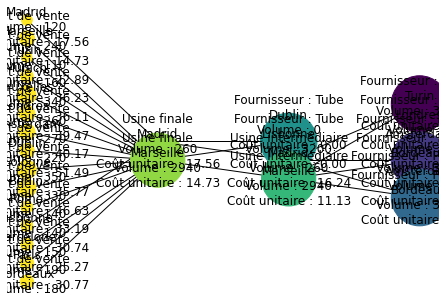

Arborescence usine intermediaire :
	 Turin
		 Tissus ('Turin', 0.0)
		 Mousse ('Bordeaux', 6.84)
		 Plastique ('Bordeaux', 5.135135135135135)
		 totalCost 11.975135135135135
		 Volume 0
	 Munich
		 Tissus ('Turin', 2.94)
		 Mousse ('Amsterdam', 6.784)
		 Plastique ('Amsterdam', 5.093093093093093)
		 totalCost 14.817093093093092
		 Volume 0
	 Bruxelles
		 Tissus ('Londres', 1.32)
		 Mousse ('Amsterdam', 1.696)
		 Plastique ('Amsterdam', 1.2732732732732732)
		 totalCost 4.289273273273273
		 Volume 0

Arborescence usine finale :
	 Turin
		 Tube ('Dublin', 3.694)
		 Usine_i ('Turin', 12.850299401197605)
		 totalCost 15.669135135135136
		 Volume 0
	 Munich
		 Tube ('Dublin', 3.418)
		 Usine_i ('Bruxelles', 9.48502994011976)
		 totalCost 17.192303213393032
		 Volume 0
	 Bruxelles
		 Tube ('Dublin', 1.862)
		 Usine_i ('Bruxelles', 0.0)
		 totalCost 6.151273273273273
		 Volume 0

Arborescence point de vente :
	 Madrid
		 Usine_f Bruxelles
		 totalCost 39.651273273273276
		 Volume 120
	 Marseil

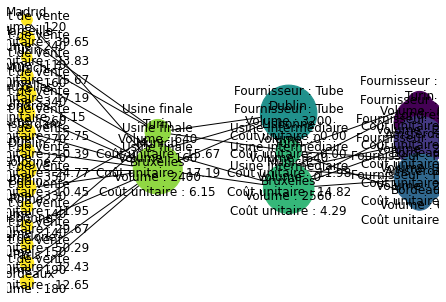

Arborescence usine intermediaire :
	 Marseille
		 Tissus ('Turin', 1.632)
		 Mousse ('Bordeaux', 5.424)
		 Plastique ('Bordeaux', 4.072072072072072)
		 totalCost 11.128072072072072
		 Volume 0
	 Munich
		 Tissus ('Turin', 2.94)
		 Mousse ('Amsterdam', 6.784)
		 Plastique ('Amsterdam', 5.093093093093093)
		 totalCost 14.817093093093092
		 Volume 0
	 Bruxelles
		 Tissus ('Londres', 1.32)
		 Mousse ('Amsterdam', 1.696)
		 Plastique ('Amsterdam', 1.2732732732732732)
		 totalCost 4.289273273273273
		 Volume 0

Arborescence usine finale :
	 Marseille
		 Tube ('Lisbonne', 3.6)
		 Usine_i ('Marseille', 12.802395209580839)
		 totalCost 14.728072072072072
		 Volume 0
	 Munich
		 Tube ('Dublin', 3.418)
		 Usine_i ('Bruxelles', 9.48502994011976)
		 totalCost 17.192303213393032
		 Volume 0
	 Bruxelles
		 Tube ('Dublin', 1.862)
		 Usine_i ('Bruxelles', 0.0)
		 totalCost 6.151273273273273
		 Volume 0

Arborescence point de vente :
	 Madrid
		 Usine_f Marseille
		 totalCost 37.76807207207207
		 Volume

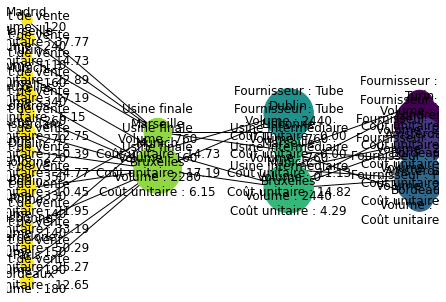

Arborescence usine intermediaire :
	 Madrid
		 Tissus ('Turin', 5.852)
		 Mousse ('Bordeaux', 5.936)
		 Plastique ('Bordeaux', 4.456456456456457)
		 totalCost 16.244456456456458
		 Volume 0
	 Munich
		 Tissus ('Turin', 2.94)
		 Mousse ('Amsterdam', 6.784)
		 Plastique ('Amsterdam', 5.093093093093093)
		 totalCost 14.817093093093092
		 Volume 0
	 Bruxelles
		 Tissus ('Londres', 1.32)
		 Mousse ('Amsterdam', 1.696)
		 Plastique ('Amsterdam', 1.2732732732732732)
		 totalCost 4.289273273273273
		 Volume 0

Arborescence usine finale :
	 Madrid
		 Tube ('Lisbonne', 1.318)
		 Usine_i ('Madrid', 20.059880239520957)
		 totalCost 17.56245645645646
		 Volume 0
	 Munich
		 Tube ('Dublin', 3.418)
		 Usine_i ('Bruxelles', 9.48502994011976)
		 totalCost 17.192303213393032
		 Volume 0
	 Bruxelles
		 Tube ('Dublin', 1.862)
		 Usine_i ('Bruxelles', 0.0)
		 totalCost 6.151273273273273
		 Volume 0

Arborescence point de vente :
	 Madrid
		 Usine_f Madrid
		 totalCost 17.56245645645646
		 Volume 120
	 Mars

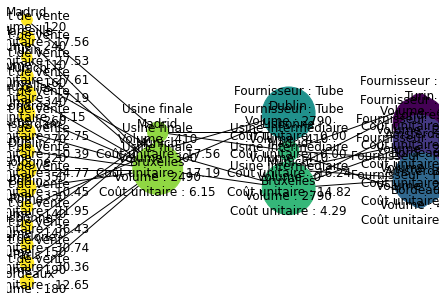

Arborescence usine intermediaire :
	 Marseille
		 Tissus ('Turin', 1.632)
		 Mousse ('Bordeaux', 5.424)
		 Plastique ('Bordeaux', 4.072072072072072)
		 totalCost 11.128072072072072
		 Volume 0
	 Turin
		 Tissus ('Turin', 0.0)
		 Mousse ('Bordeaux', 6.84)
		 Plastique ('Bordeaux', 5.135135135135135)
		 totalCost 11.975135135135135
		 Volume 0
	 Bruxelles
		 Tissus ('Londres', 1.32)
		 Mousse ('Amsterdam', 1.696)
		 Plastique ('Amsterdam', 1.2732732732732732)
		 totalCost 4.289273273273273
		 Volume 0

Arborescence usine finale :
	 Marseille
		 Tube ('Lisbonne', 3.6)
		 Usine_i ('Marseille', 12.802395209580839)
		 totalCost 14.728072072072072
		 Volume 0
	 Turin
		 Tube ('Dublin', 3.694)
		 Usine_i ('Turin', 12.850299401197605)
		 totalCost 15.669135135135136
		 Volume 0
	 Bruxelles
		 Tube ('Dublin', 1.862)
		 Usine_i ('Bruxelles', 0.0)
		 totalCost 6.151273273273273
		 Volume 0

Arborescence point de vente :
	 Madrid
		 Usine_f Marseille
		 totalCost 37.76807207207207
		 Volume 120
	 M

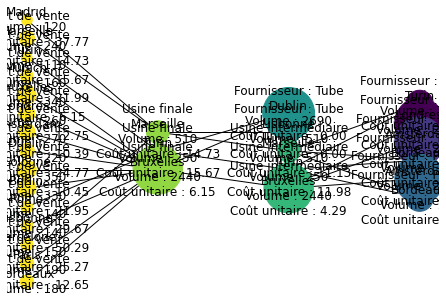

Arborescence usine intermediaire :
	 Madrid
		 Tissus ('Turin', 5.852)
		 Mousse ('Bordeaux', 5.936)
		 Plastique ('Bordeaux', 4.456456456456457)
		 totalCost 16.244456456456458
		 Volume 0
	 Turin
		 Tissus ('Turin', 0.0)
		 Mousse ('Bordeaux', 6.84)
		 Plastique ('Bordeaux', 5.135135135135135)
		 totalCost 11.975135135135135
		 Volume 0
	 Bruxelles
		 Tissus ('Londres', 1.32)
		 Mousse ('Amsterdam', 1.696)
		 Plastique ('Amsterdam', 1.2732732732732732)
		 totalCost 4.289273273273273
		 Volume 0

Arborescence usine finale :
	 Madrid
		 Tube ('Lisbonne', 1.318)
		 Usine_i ('Madrid', 20.059880239520957)
		 totalCost 17.56245645645646
		 Volume 0
	 Turin
		 Tube ('Dublin', 3.694)
		 Usine_i ('Turin', 12.850299401197605)
		 totalCost 15.669135135135136
		 Volume 0
	 Bruxelles
		 Tube ('Dublin', 1.862)
		 Usine_i ('Bruxelles', 0.0)
		 totalCost 6.151273273273273
		 Volume 0

Arborescence point de vente :
	 Madrid
		 Usine_f Madrid
		 totalCost 17.56245645645646
		 Volume 120
	 Marseille
		

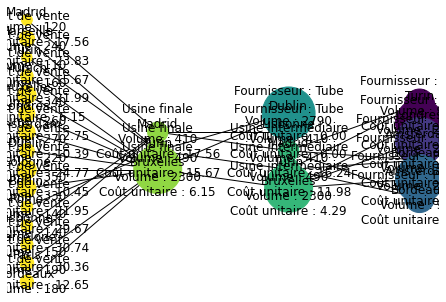

Arborescence usine intermediaire :
	 Marseille
		 Tissus ('Turin', 1.632)
		 Mousse ('Bordeaux', 5.424)
		 Plastique ('Bordeaux', 4.072072072072072)
		 totalCost 11.128072072072072
		 Volume 0
	 Turin
		 Tissus ('Turin', 0.0)
		 Mousse ('Bordeaux', 6.84)
		 Plastique ('Bordeaux', 5.135135135135135)
		 totalCost 11.975135135135135
		 Volume 0
	 Munich
		 Tissus ('Turin', 2.94)
		 Mousse ('Amsterdam', 6.784)
		 Plastique ('Amsterdam', 5.093093093093093)
		 totalCost 14.817093093093092
		 Volume 0

Arborescence usine finale :
	 Marseille
		 Tube ('Lisbonne', 3.6)
		 Usine_i ('Marseille', 12.874251497005988)
		 totalCost 14.728072072072072
		 Volume 0
	 Turin
		 Tube ('Dublin', 3.694)
		 Usine_i ('Turin', 8.802395209580839)
		 totalCost 15.669135135135136
		 Volume 0
	 Munich
		 Tube ('Dublin', 3.418)
		 Usine_i ('Munich', 0.0)
		 totalCost 18.23509309309309
		 Volume 0

Arborescence point de vente :
	 Madrid
		 Usine_f Marseille
		 totalCost 37.76807207207207
		 Volume 120
	 Marseille
		 

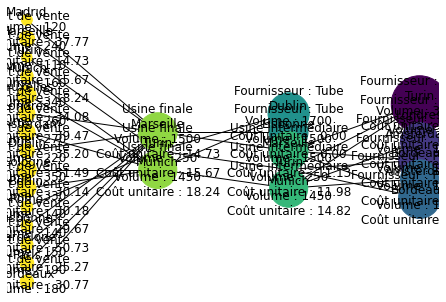

Arborescence usine intermediaire :
	 Madrid
		 Tissus ('Turin', 5.852)
		 Mousse ('Bordeaux', 5.936)
		 Plastique ('Bordeaux', 4.456456456456457)
		 totalCost 16.244456456456458
		 Volume 0
	 Turin
		 Tissus ('Turin', 0.0)
		 Mousse ('Bordeaux', 6.84)
		 Plastique ('Bordeaux', 5.135135135135135)
		 totalCost 11.975135135135135
		 Volume 0
	 Munich
		 Tissus ('Turin', 2.94)
		 Mousse ('Amsterdam', 6.784)
		 Plastique ('Amsterdam', 5.093093093093093)
		 totalCost 14.817093093093092
		 Volume 0

Arborescence usine finale :
	 Madrid
		 Tube ('Lisbonne', 1.318)
		 Usine_i ('Madrid', 24.934131736526947)
		 totalCost 17.56245645645646
		 Volume 0
	 Turin
		 Tube ('Dublin', 3.694)
		 Usine_i ('Turin', 8.802395209580839)
		 totalCost 15.669135135135136
		 Volume 0
	 Munich
		 Tube ('Dublin', 3.418)
		 Usine_i ('Munich', 0.0)
		 totalCost 18.23509309309309
		 Volume 0

Arborescence point de vente :
	 Madrid
		 Usine_f Madrid
		 totalCost 17.56245645645646
		 Volume 120
	 Marseille
		 Usine_f Tur

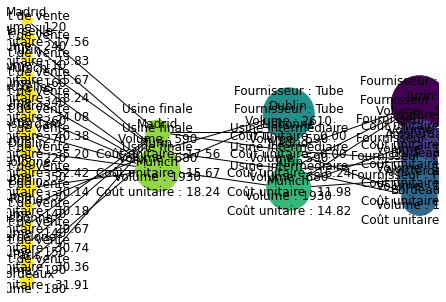

Arborescence usine intermediaire :
	 Madrid
		 Tissus ('Turin', 5.852)
		 Mousse ('Bordeaux', 5.936)
		 Plastique ('Bordeaux', 4.456456456456457)
		 totalCost 16.244456456456458
		 Volume 0
	 Marseille
		 Tissus ('Turin', 1.632)
		 Mousse ('Bordeaux', 5.424)
		 Plastique ('Bordeaux', 4.072072072072072)
		 totalCost 11.128072072072072
		 Volume 0
	 Turin
		 Tissus ('Turin', 0.0)
		 Mousse ('Bordeaux', 6.84)
		 Plastique ('Bordeaux', 5.135135135135135)
		 totalCost 11.975135135135135
		 Volume 0

Arborescence usine finale :
	 Madrid
		 Tube ('Lisbonne', 1.318)
		 Usine_i ('Madrid', 17.520958083832337)
		 totalCost 17.56245645645646
		 Volume 0
	 Marseille
		 Tube ('Lisbonne', 3.6)
		 Usine_i ('Marseille', 4.88622754491018)
		 totalCost 14.728072072072072
		 Volume 0
	 Turin
		 Tube ('Dublin', 3.694)
		 Usine_i ('Turin', 0.0)
		 totalCost 15.669135135135136
		 Volume 0

Arborescence point de vente :
	 Madrid
		 Usine_f Madrid
		 totalCost 17.56245645645646
		 Volume 120
	 Marseille
		 Usi

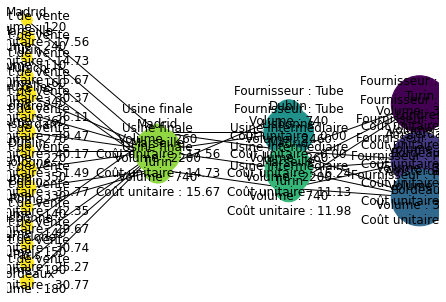

Arborescence usine intermediaire :
	 Madrid
		 Tissus ('Turin', 5.852)
		 Mousse ('Bordeaux', 5.936)
		 Plastique ('Bordeaux', 4.456456456456457)
		 totalCost 16.244456456456458
		 Volume 0
	 Marseille
		 Tissus ('Turin', 1.632)
		 Mousse ('Bordeaux', 5.424)
		 Plastique ('Bordeaux', 4.072072072072072)
		 totalCost 11.128072072072072
		 Volume 0
	 Bruxelles
		 Tissus ('Londres', 1.32)
		 Mousse ('Amsterdam', 1.696)
		 Plastique ('Amsterdam', 1.2732732732732732)
		 totalCost 4.289273273273273
		 Volume 0

Arborescence usine finale :
	 Madrid
		 Tube ('Lisbonne', 1.318)
		 Usine_i ('Madrid', 20.059880239520957)
		 totalCost 17.56245645645646
		 Volume 0
	 Marseille
		 Tube ('Lisbonne', 3.6)
		 Usine_i ('Marseille', 12.802395209580839)
		 totalCost 14.728072072072072
		 Volume 0
	 Bruxelles
		 Tube ('Dublin', 1.862)
		 Usine_i ('Bruxelles', 0.0)
		 totalCost 6.151273273273273
		 Volume 0

Arborescence point de vente :
	 Madrid
		 Usine_f Madrid
		 totalCost 17.56245645645646
		 Volume 120

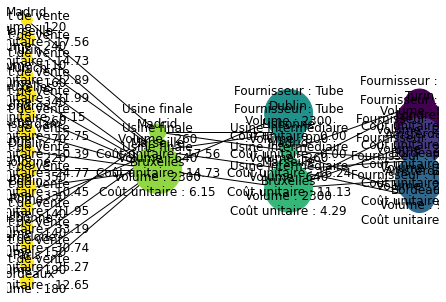

Arborescence usine intermediaire :
	 Madrid
		 Tissus ('Turin', 5.852)
		 Mousse ('Bordeaux', 5.936)
		 Plastique ('Bordeaux', 4.456456456456457)
		 totalCost 16.244456456456458
		 Volume 0
	 Marseille
		 Tissus ('Turin', 1.632)
		 Mousse ('Bordeaux', 5.424)
		 Plastique ('Bordeaux', 4.072072072072072)
		 totalCost 11.128072072072072
		 Volume 0
	 Munich
		 Tissus ('Turin', 2.94)
		 Mousse ('Amsterdam', 6.784)
		 Plastique ('Amsterdam', 5.093093093093093)
		 totalCost 14.817093093093092
		 Volume 0

Arborescence usine finale :
	 Madrid
		 Tube ('Lisbonne', 1.318)
		 Usine_i ('Madrid', 24.934131736526947)
		 totalCost 17.56245645645646
		 Volume 0
	 Marseille
		 Tube ('Lisbonne', 3.6)
		 Usine_i ('Marseille', 12.874251497005988)
		 totalCost 14.728072072072072
		 Volume 0
	 Munich
		 Tube ('Dublin', 3.418)
		 Usine_i ('Munich', 0.0)
		 totalCost 18.23509309309309
		 Volume 0

Arborescence point de vente :
	 Madrid
		 Usine_f Madrid
		 totalCost 17.56245645645646
		 Volume 120
	 Marseill

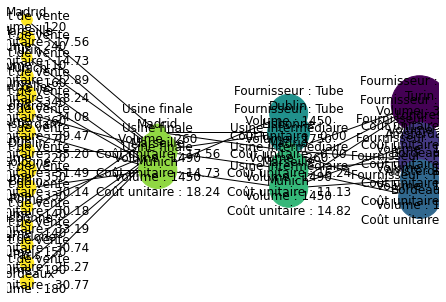

Arborescence usine intermediaire :
	 Marseille
		 Tissus ('Turin', 1.632)
		 Mousse ('Bordeaux', 5.424)
		 Plastique ('Bordeaux', 4.072072072072072)
		 totalCost 11.128072072072072
		 Volume 0
	 Turin
		 Tissus ('Turin', 0.0)
		 Mousse ('Bordeaux', 6.84)
		 Plastique ('Bordeaux', 5.135135135135135)
		 totalCost 11.975135135135135
		 Volume 0
	 Munich
		 Tissus ('Turin', 2.94)
		 Mousse ('Amsterdam', 6.784)
		 Plastique ('Amsterdam', 5.093093093093093)
		 totalCost 14.817093093093092
		 Volume 0
	 Bruxelles
		 Tissus ('Londres', 1.32)
		 Mousse ('Amsterdam', 1.696)
		 Plastique ('Amsterdam', 1.2732732732732732)
		 totalCost 4.289273273273273
		 Volume 0

Arborescence usine finale :
	 Marseille
		 Tube ('Lisbonne', 3.6)
		 Usine_i ('Marseille', 12.802395209580839)
		 totalCost 14.728072072072072
		 Volume 0
	 Turin
		 Tube ('Dublin', 3.694)
		 Usine_i ('Turin', 12.850299401197605)
		 totalCost 15.669135135135136
		 Volume 0
	 Munich
		 Tube ('Dublin', 3.418)
		 Usine_i ('Bruxelles', 9.48

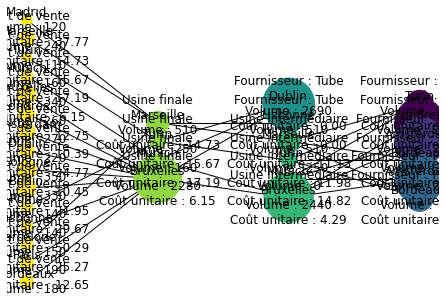

Arborescence usine intermediaire :
	 Madrid
		 Tissus ('Turin', 5.852)
		 Mousse ('Bordeaux', 5.936)
		 Plastique ('Bordeaux', 4.456456456456457)
		 totalCost 16.244456456456458
		 Volume 0
	 Turin
		 Tissus ('Turin', 0.0)
		 Mousse ('Bordeaux', 6.84)
		 Plastique ('Bordeaux', 5.135135135135135)
		 totalCost 11.975135135135135
		 Volume 0
	 Munich
		 Tissus ('Turin', 2.94)
		 Mousse ('Amsterdam', 6.784)
		 Plastique ('Amsterdam', 5.093093093093093)
		 totalCost 14.817093093093092
		 Volume 0
	 Bruxelles
		 Tissus ('Londres', 1.32)
		 Mousse ('Amsterdam', 1.696)
		 Plastique ('Amsterdam', 1.2732732732732732)
		 totalCost 4.289273273273273
		 Volume 0

Arborescence usine finale :
	 Madrid
		 Tube ('Lisbonne', 1.318)
		 Usine_i ('Madrid', 20.059880239520957)
		 totalCost 17.56245645645646
		 Volume 0
	 Turin
		 Tube ('Dublin', 3.694)
		 Usine_i ('Turin', 12.850299401197605)
		 totalCost 15.669135135135136
		 Volume 0
	 Munich
		 Tube ('Dublin', 3.418)
		 Usine_i ('Bruxelles', 9.4850299401

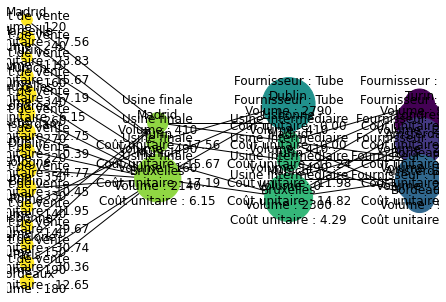

Arborescence usine intermediaire :
	 Madrid
		 Tissus ('Turin', 5.852)
		 Mousse ('Bordeaux', 5.936)
		 Plastique ('Bordeaux', 4.456456456456457)
		 totalCost 16.244456456456458
		 Volume 0
	 Marseille
		 Tissus ('Turin', 1.632)
		 Mousse ('Bordeaux', 5.424)
		 Plastique ('Bordeaux', 4.072072072072072)
		 totalCost 11.128072072072072
		 Volume 0
	 Munich
		 Tissus ('Turin', 2.94)
		 Mousse ('Amsterdam', 6.784)
		 Plastique ('Amsterdam', 5.093093093093093)
		 totalCost 14.817093093093092
		 Volume 0
	 Bruxelles
		 Tissus ('Londres', 1.32)
		 Mousse ('Amsterdam', 1.696)
		 Plastique ('Amsterdam', 1.2732732732732732)
		 totalCost 4.289273273273273
		 Volume 0

Arborescence usine finale :
	 Madrid
		 Tube ('Lisbonne', 1.318)
		 Usine_i ('Madrid', 20.059880239520957)
		 totalCost 17.56245645645646
		 Volume 0
	 Marseille
		 Tube ('Lisbonne', 3.6)
		 Usine_i ('Marseille', 12.802395209580839)
		 totalCost 14.728072072072072
		 Volume 0
	 Munich
		 Tube ('Dublin', 3.418)
		 Usine_i ('Bruxelles

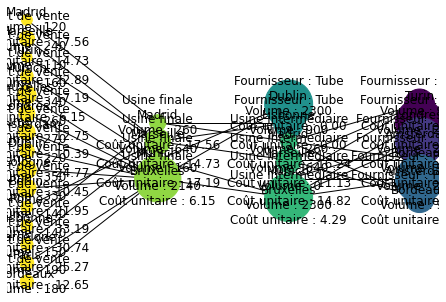

Arborescence usine intermediaire :
	 Madrid
		 Tissus ('Turin', 5.852)
		 Mousse ('Bordeaux', 5.936)
		 Plastique ('Bordeaux', 4.456456456456457)
		 totalCost 16.244456456456458
		 Volume 0
	 Marseille
		 Tissus ('Turin', 1.632)
		 Mousse ('Bordeaux', 5.424)
		 Plastique ('Bordeaux', 4.072072072072072)
		 totalCost 11.128072072072072
		 Volume 0
	 Turin
		 Tissus ('Turin', 0.0)
		 Mousse ('Bordeaux', 6.84)
		 Plastique ('Bordeaux', 5.135135135135135)
		 totalCost 11.975135135135135
		 Volume 0
	 Bruxelles
		 Tissus ('Londres', 1.32)
		 Mousse ('Amsterdam', 1.696)
		 Plastique ('Amsterdam', 1.2732732732732732)
		 totalCost 4.289273273273273
		 Volume 0

Arborescence usine finale :
	 Madrid
		 Tube ('Lisbonne', 1.318)
		 Usine_i ('Madrid', 20.059880239520957)
		 totalCost 17.56245645645646
		 Volume 0
	 Marseille
		 Tube ('Lisbonne', 3.6)
		 Usine_i ('Marseille', 12.802395209580839)
		 totalCost 14.728072072072072
		 Volume 0
	 Turin
		 Tube ('Dublin', 3.694)
		 Usine_i ('Turin', 12.8502

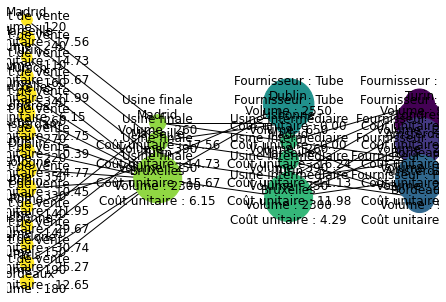

Arborescence usine intermediaire :
	 Madrid
		 Tissus ('Turin', 5.852)
		 Mousse ('Bordeaux', 5.936)
		 Plastique ('Bordeaux', 4.456456456456457)
		 totalCost 16.244456456456458
		 Volume 0
	 Marseille
		 Tissus ('Turin', 1.632)
		 Mousse ('Bordeaux', 5.424)
		 Plastique ('Bordeaux', 4.072072072072072)
		 totalCost 11.128072072072072
		 Volume 0
	 Turin
		 Tissus ('Turin', 0.0)
		 Mousse ('Bordeaux', 6.84)
		 Plastique ('Bordeaux', 5.135135135135135)
		 totalCost 11.975135135135135
		 Volume 0
	 Munich
		 Tissus ('Turin', 2.94)
		 Mousse ('Amsterdam', 6.784)
		 Plastique ('Amsterdam', 5.093093093093093)
		 totalCost 14.817093093093092
		 Volume 0

Arborescence usine finale :
	 Madrid
		 Tube ('Lisbonne', 1.318)
		 Usine_i ('Madrid', 24.934131736526947)
		 totalCost 17.56245645645646
		 Volume 0
	 Marseille
		 Tube ('Lisbonne', 3.6)
		 Usine_i ('Marseille', 12.874251497005988)
		 totalCost 14.728072072072072
		 Volume 0
	 Turin
		 Tube ('Dublin', 3.694)
		 Usine_i ('Turin', 8.8023952095

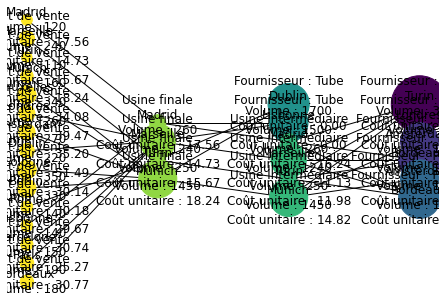

Arborescence usine intermediaire :
	 Madrid
		 Tissus ('Turin', 5.852)
		 Mousse ('Bordeaux', 5.936)
		 Plastique ('Bordeaux', 4.456456456456457)
		 totalCost 16.244456456456458
		 Volume 0
	 Marseille
		 Tissus ('Turin', 1.632)
		 Mousse ('Bordeaux', 5.424)
		 Plastique ('Bordeaux', 4.072072072072072)
		 totalCost 11.128072072072072
		 Volume 0
	 Turin
		 Tissus ('Turin', 0.0)
		 Mousse ('Bordeaux', 6.84)
		 Plastique ('Bordeaux', 5.135135135135135)
		 totalCost 11.975135135135135
		 Volume 0
	 Munich
		 Tissus ('Turin', 2.94)
		 Mousse ('Amsterdam', 6.784)
		 Plastique ('Amsterdam', 5.093093093093093)
		 totalCost 14.817093093093092
		 Volume 0
	 Bruxelles
		 Tissus ('Londres', 1.32)
		 Mousse ('Amsterdam', 1.696)
		 Plastique ('Amsterdam', 1.2732732732732732)
		 totalCost 4.289273273273273
		 Volume 0

Arborescence usine finale :
	 Madrid
		 Tube ('Lisbonne', 1.318)
		 Usine_i ('Madrid', 20.059880239520957)
		 totalCost 17.56245645645646
		 Volume 0
	 Marseille
		 Tube ('Lisbonne', 

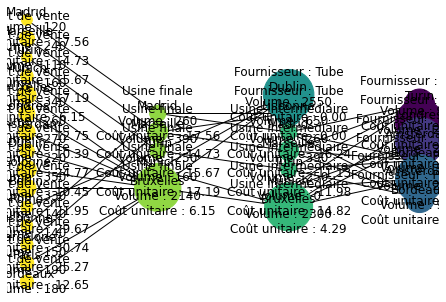

In [7]:
df=[]
for archi in table_usines_f :
    couts = opti_archi(archi)
    cout_aff, cout_amo = couts[0],couts[1]
    
    nb_usines_f = sum(archi)
    
    df.append([cout_aff,cout_amo,nb_usines_f]+archi)

df = pd.DataFrame(df,columns=["cout_aff","cout_amo",'nb_usines_f','Madrid','Marseille','Turin','Munich','Bruxelles'])

<AxesSubplot:>

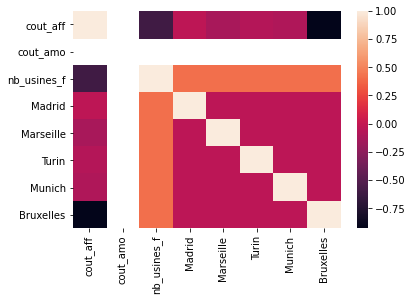

In [31]:
sns.heatmap(df.corr())

In [33]:
df[df['Bruxelles']==1]

cout_aff  cout_amo  nb_usines_f  Madrid  Marseille  Turin  Munich  \
0   67223.074474      4395            1       0          0      0       0   
5   65839.383457      4395            2       0          0      0       1   
6   63193.906066      4395            2       0          0      1       0   
7   60996.241562      4395            2       0          1      0       0   
8   61261.259580      4395            2       1          0      0       0   
15  62426.070856      4395            3       0          0      1       1   
16  60228.406352      4395            3       0          1      0       1   
17  59877.568562      4395            3       1          0      0       1   
18  59709.507327      4395            3       0          1      1       0   
19  57496.411892      4395            3       1          0      1       0   
23  55834.733333      4395            3       1          1      0       0   
25  58941.672118      4395            4       0          1      1       1   
26  56728.576682      4395            4       1          0      1       1   
27  55066.898124      4395            4       1          1      0       1   
28  54547.999099      4395            4       1          1      1       0   
30  53780.163890      4395            5       1          1      1       1   

    Bruxelles  
0           1  
5           1  
6           1  
7           1  
8           1  
15          1  
16          1  
17          1  
18          1  
19          1  
23          1  
25          1  
26          1  
27          1  
28          1  
30          1

In [34]:
df[df['Bruxelles']==0]

cout_aff  cout_amo  nb_usines_f  Madrid  Marseille  Turin  Munich  \
1   123888.097898      4395            1       0          0      0       1   
2   119407.432432      4395            1       0          0      1       0   
3   115474.630631      4395            1       0          1      0       0   
4   159246.260661      4395            1       1          0      0       0   
9   108457.531291      4395            2       0          0      1       1   
10  103160.811111      4395            2       0          1      0       1   
11  108389.042282      4395            2       1          0      0       1   
12  111838.417297      4395            2       0          1      1       0   
13  111946.892012      4395            2       1          0      1       0   
14  110251.970571      4395            2       1          1      0       0   
20  101874.076877      4395            3       0          1      1       1   
21  100996.990871      4395            3       1          0      1       1   
22  106615.757237      4395            3       1          1      1       0   
24   97938.151051      4395            3       1          1      0       1   
29   96651.416817      4395            4       1          1      1       1   

    Bruxelles  
1           0  
2           0  
3           0  
4           0  
9           0  
10          0  
11          0  
12          0  
13          0  
14          0  
20          0  
21          0  
22          0  
24          0  
29          0

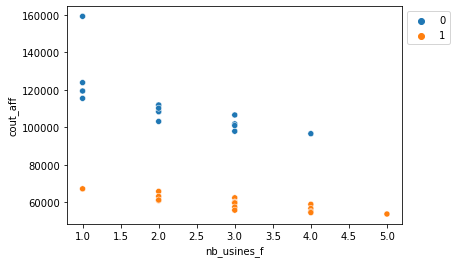

In [10]:
sns.scatterplot(x='nb_usines_f', y='cout_aff', hue='Bruxelles', data=df, )
plt.legend(bbox_to_anchor=(1, 1), loc=2) # Displays the legend outside the graph
plt.show()